In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import mdtraj as md


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import pickle

## Import data

In [4]:
indir = './Data/Chodera_data/Selection/'
topfile =  indir+'/a1e-solute.pdb'
from glob import glob
selection_nc = glob(indir+'/*.nc')
print(len(selection_nc))

500


In [5]:
timestep = 0.1

## Create observed MSM

In [6]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=False)


In [7]:
inp = coor.source(selection_nc, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

A Jupyter Widget

number of trajectories =  500
trajectory length =  1000
number of dimension =  2


In [8]:
n_clusters=500
clustering = coor.cluster_kmeans(inp,k=n_clusters, max_iter=500)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

22-01-18 15:49:20 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 13 steps.


In [9]:
dtrajs = clustering.dtrajs


A Jupyter Widget

In [10]:
its = msm.timescales_msm(dtrajs, lags=np.arange(20), nits=10, n_jobs=-1)


22-01-18 15:49:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Ignored error during estimation: row, column, and data array must all be the same length


A Jupyter Widget

22-01-18 15:50:20 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Estimation has failed at lagtimes: [0]. Run single-lag estimation at these lags to track down the error.
22-01-18 15:50:22 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


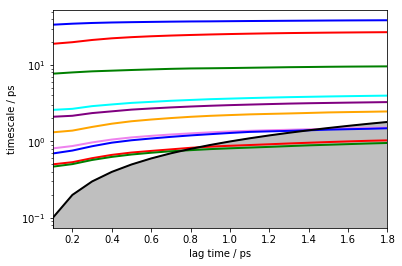

In [11]:
mplt.plot_implied_timescales(its, ylog=True, dt=0.1, units='ps', linewidth=2)


In [12]:
ftrajs = inp.get_output()

A Jupyter Widget

In [13]:
fxx = np.concatenate(ftrajs)

In [14]:
msm_lag = 10
M = msm.estimate_markov_model(dtrajs, msm_lag)
len(M.active_set)

500

## Create HMM

In [15]:
n_sets = 4
HMM = M.coarse_grain(n_sets)
pcca_dist = HMM.metastable_distributions
membership = HMM.metastable_memberships 


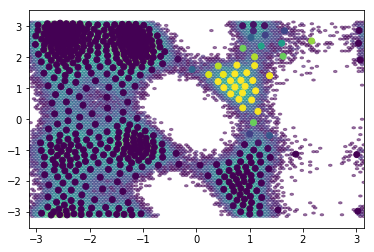

In [16]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.5)
plt.scatter(clustering.clustercenters[:,0],clustering.clustercenters[:,1],c=membership[:,0])

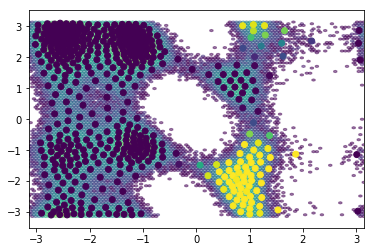

In [17]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.5)
plt.scatter(clustering.clustercenters[:,0],clustering.clustercenters[:,1],c=membership[:,1])

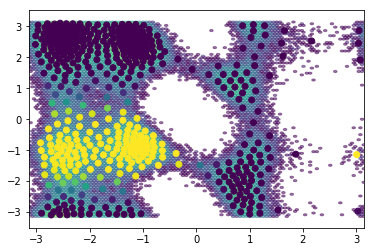

In [18]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.5)
plt.scatter(clustering.clustercenters[:,0],clustering.clustercenters[:,1],c=membership[:,2])

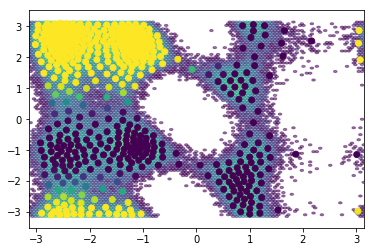

In [19]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.5)
plt.scatter(clustering.clustercenters[:,0],clustering.clustercenters[:,1],c=membership[:,3])

# Artificial Trajectory

## Generate discrete artificial trajectory

In [20]:
dt = 1 # 1 ps
htraj, otraj = HMM.simulate(500000, start=0, dt=1)

In [21]:
np.save('Data/Chodera_data/Processed/htraj_lag{}ps.npy'.format(dt*msm_lag*timestep), htraj)

In [22]:
np.save('Data/Chodera_data/Processed/otraj_lag{}ps.npy'.format(dt*msm_lag*timestep), otraj)

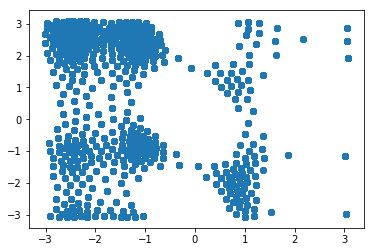

In [23]:
plt.scatter(clustering.clustercenters[otraj,0],clustering.clustercenters[otraj,1])

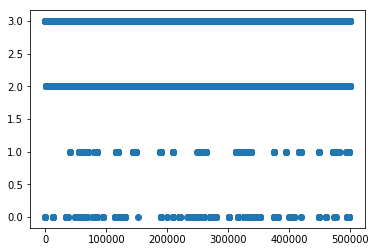

In [24]:
plt.scatter(range(len(htraj)),htraj)

## Create  artificial trajectory from mdtraj 

In [25]:
traj_idx = clustering.sample_indexes_by_cluster(otraj, nsample=1)

In [26]:
traj_idx = np.concatenate(traj_idx)

In [27]:
np.save('Data/Chodera_data/Processed/cluster_samples_index_lag{}ps.npy'.format(dt*msm_lag*timestep), traj_idx)

In [28]:
pickle.dump(selection_nc, open('Data/Chodera_data/Processed/cluster_samples_filenames_lag{}ps.pickle'.format(dt*msm_lag*timestep), 'wb'))

## Probabilistic Trajectories

In [29]:
membership_trajs =  [membership[:,i][otraj][:, np.newaxis] for i in range(n_sets)]

In [30]:
membership_traj = np.concatenate(membership_trajs, axis=1)

In [31]:
membership_traj

array([[  3.03378817e-001,   6.96621183e-001,   4.95788421e-160,
          3.19624815e-138],
       [  1.00000000e+000,   5.74871355e-081,   2.41506151e-176,
          3.43964752e-113],
       [  1.00000000e+000,   4.52703216e-114,   1.08161860e-171,
          1.14436997e-108],
       ..., 
       [  9.18000541e-050,   3.03285928e-265,   2.53348319e-091,
          1.00000000e+000],
       [  4.64925385e-116,   5.80537134e-257,   2.72542997e-094,
          1.00000000e+000],
       [  3.90296187e-005,   4.57472249e-212,   2.19102247e-125,
          9.99960970e-001]])

In [32]:
np.save('Data/Chodera_data/Processed/probabilistic_traj_lag{}ps.npy'.format(dt*msm_lag*timestep), membership_traj)

# Save results

In [33]:
pickle.dump(HMM, open('Data/Chodera_data/Processed/HMM_lag{}.pickle'.format(msm_lag*timestep), 'wb'))

In [34]:
pickle.dump(M, open('Data/Chodera_data/Processed/MSM_lag{}.pickle'.format(msm_lag*timestep), 'wb'))

In [35]:
pickle.dump(HMM, open('Data/Chodera_data/Processed/clustering.pickle', 'wb'))

In [39]:
HMM.observation_probabilities[0].sum()
HMM.observation_probabilities.shape

(4, 500)

In [40]:
hmm_samples = HMM.sample_by_observation_probabilities(100)


In [43]:
from os.path import join
save_dir = 'Data/Chodera_data/Processed/'
outfiles = [join(save_dir, 'state-{}.pdb'.format(i+1)) for i in range(n_sets)]
coor.save_trajs(inp, hmm_samples, outfiles=outfiles)


['Data/Chodera_data/Processed/state-1.pdb',
 'Data/Chodera_data/Processed/state-2.pdb',
 'Data/Chodera_data/Processed/state-3.pdb',
 'Data/Chodera_data/Processed/state-4.pdb']